In [11]:
import dask.diagnostics
import faceted
import matplotlib as mpl
import pandas as pd
import numpy as np
import xarray as xr

import plotting
import utils

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from upath import UPath

In [12]:
plotting.configure_style()

In [13]:
catalog = utils.open_catalog()
regridder = utils.get_regridder()

In [14]:
CLIMATES = ["1xCO2", "3xCO2"]
INITIAL_CONDITIONS = [f"ic{n}" for n in range(1, 6)]

REFERENCE = "SHiELD-SOM-C96"
ACE2_SOM = "ACE2-SOM-multi-climate-RS3"

MODELS = [REFERENCE, ACE2_SOM]
FILENAME = "autoregressive_predictions.nc"

In [15]:
cases = catalog[
    catalog["initial_condition"].isin(INITIAL_CONDITIONS)
    & catalog["model"].isin(MODELS)
    & catalog["forcing"].isin(CLIMATES)
    & (catalog["tag"] == "extreme-precipitation")
]

In [16]:
ROOT = UPath("gs://vcm-ml-intermediate/2024-07-09-vertically-resolved-1deg-c96-shield-som-ensemble-fme-dataset")
datasets = {}
for climate in CLIMATES:
    for ic in range(1, 6):
        key = climate, ic
        datasets[key] = utils.scale_precipitation(xr.open_zarr(ROOT / f"{climate}-ic_000{ic}.zarr"))
index = pd.MultiIndex.from_tuples(datasets.keys(), names=["climate", "initial_condition"])
combined = utils.safe_concat(datasets.values(), dim="case")
ds = combined.assign_coords(case=index).unstack("case")

/tmp/ipykernel_14970/3224939264.py:9: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'case' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds = combined.assign_coords(case=index).unstack("case")


In [17]:
with dask.diagnostics.ProgressBar():
    minimum_precipitation = ds.PRATEsfc.coarsen(time=4).mean().min().compute()
    maximum_precipitation = ds.PRATEsfc.coarsen(time=4).mean().max().compute()

[########################################] | 100% Completed | 393.28 s
[########################################] | 100% Completed | 390.58 s


In [18]:
print(minimum_precipitation)
print(maximum_precipitation)

<xarray.DataArray 'PRATEsfc' ()> Size: 8B
array(-33.39627317)
<xarray.DataArray 'PRATEsfc' ()> Size: 8B
array(881.4476531)


In [19]:
nbins = 100
bins = np.linspace(-50, 900, nbins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

We do not have enough memory to compute the histograms with the full dataset all at once; therefore we compute them iteratively and aggregrate at the end.

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

/tmp/ipykernel_14970/3967498646.py:17: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'case' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds = combined.assign_coords(case=index).unstack("case")


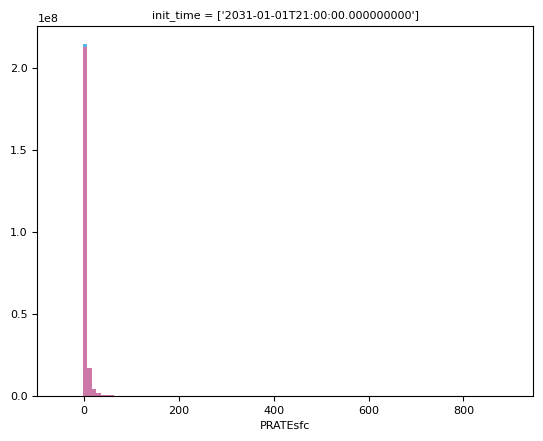

In [20]:
datasets = {}
for _, case in cases.iterrows():
    model = case["model"]
    climate = case["forcing"]
    beaker_id = case["beaker_id"]
    initial_condition = case["initial_condition"]
    key = model, climate, initial_condition
    ds = utils.open_beaker_dataset(beaker_id, FILENAME, ["PRATEsfc"])
    ds = utils.scale_precipitation(ds)
    counts, _, _ = ds.PRATEsfc.plot.hist(bins=bins)
    datasets[key] = xr.DataArray(counts, dims=["bin"], coords=[bin_centers], name="PRATEsfc")
    del ds
index = pd.MultiIndex.from_tuples(
    datasets.keys(), names=("model", "climate", "initial_condition")
)
combined = xr.concat(datasets.values(), dim="case")
ds = combined.assign_coords(case=index).unstack("case")

In [21]:
converted = {}
for key, da in datasets.items():
    converted[key] = da.to_dataset()

combined = utils.safe_concat(converted.values(), dim="case")
ds = combined.assign_coords(case=index).unstack("case")

/tmp/ipykernel_14970/2074983637.py:6: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'case' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds = combined.assign_coords(case=index).unstack("case")


In [22]:
bin_width = np.diff(bins)[0]
aggregate_density = ds.sum("initial_condition") / (bin_width * ds.sum(["initial_condition", "bin"]))
aggregate_counts = ds.sum("initial_condition")

In [23]:
percentiles = 100 * aggregate_counts.cumsum("bin").assign_coords(bin=ds.bin) / aggregate_counts.sum("bin")

This plot helps us see the percentiles at which the precipitation histograms diverge.

/tmp/ipykernel_14970/3155970642.py:24: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  ax2.legend([h1, h2], labels=["C96 SHiELD-SOM", "ACE2-SOM"])


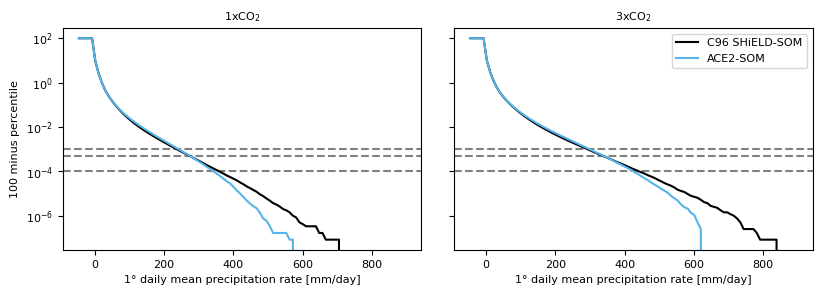

In [24]:
fig, (ax1, ax2) = faceted.faceted(1, 2, aspect=0.618)

(100 - percentiles.PRATEsfc).sel(climate="1xCO2", model=REFERENCE).plot(ax=ax1, yscale="log", color="k")
(100 - percentiles.PRATEsfc).sel(climate="1xCO2", model=ACE2_SOM).plot(ax=ax1, yscale="log")
ax1.axhline(1e-3, color="gray", ls="--", zorder=0)
ax1.axhline(0.5e-3, color="gray", ls="--", zorder=0)
ax1.axhline(1e-4, color="gray", ls="--", zorder=0)

h1 = (100 - percentiles.PRATEsfc).sel(climate="3xCO2", model=REFERENCE).plot(ax=ax2, yscale="log", color="k")
h2 = (100 - percentiles.PRATEsfc).sel(climate="3xCO2", model=ACE2_SOM).plot(ax=ax2, yscale="log")
ax2.axhline(1e-3, color="gray", ls="--", zorder=0)
ax2.axhline(0.5e-3, color="gray", ls="--", zorder=0)
ax2.axhline(1e-4, color="gray", ls="--", zorder=0)

for ax in (ax1, ax2):
    ax.set_xlabel("1° daily mean precipitation rate [mm/day]")
    ax.set_ylabel("")

ax1.set_ylabel("100 minus percentile")

ax1.set_title("1xCO$_2$")
ax2.set_title("3xCO$_2$")

ax2.legend([h1, h2], labels=["C96 SHiELD-SOM", "ACE2-SOM"])
fig.savefig("2024-12-18-percentiles.png", dpi=200, bbox_inches="tight")

In [25]:
reference_1xCO2 = percentiles.sel(climate="1xCO2", model=REFERENCE).isel(bin=slice(4, 25)).swap_dims({"bin": "PRATEsfc"}).bin.interp(PRATEsfc=99.9).item()
ace2_som_1xCO2 = percentiles.sel(climate="1xCO2", model=ACE2_SOM).isel(bin=slice(4, 25)).swap_dims({"bin": "PRATEsfc"}).bin.interp(PRATEsfc=99.9).item()

reference_3xCO2 = percentiles.sel(climate="3xCO2", model=REFERENCE).isel(bin=slice(4, 25)).swap_dims({"bin": "PRATEsfc"}).bin.interp(PRATEsfc=99.9).item()
ace2_som_3xCO2 = percentiles.sel(climate="3xCO2", model=ACE2_SOM).isel(bin=slice(4, 25)).swap_dims({"bin": "PRATEsfc"}).bin.interp(PRATEsfc=99.9).item()

print((100 * (reference_3xCO2 - reference_1xCO2) / reference_1xCO2) / 3.34)
print((100 * (ace2_som_3xCO2 - ace2_som_1xCO2) / ace2_som_1xCO2) / 3.36)


6.327873485137318
6.160572356698178


In [26]:
COLORS = {REFERENCE: "k", ACE2_SOM: "C0"}
LABELS = {REFERENCE: "100 km SHiELD-SOM", ACE2_SOM: "ACE2-SOM"}

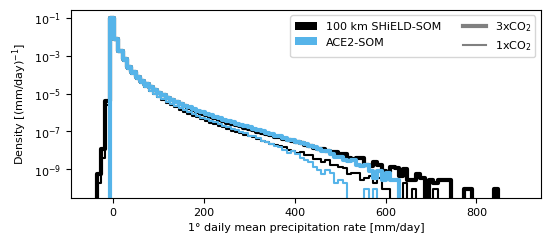

In [27]:
# mpl.rcParams["savefig.transparent"] = True
fig, (ax,) = faceted.faceted(
    1,
    1,
    aspect=0.4,
    width=5.5,
    left_pad=0.7,
    right_pad=0.1,
    bottom_pad=0.5,
    top_pad=0.1,
)

kwargs = {"yscale": "log"}

counts_3xCO2 = {}
counts_1xCO2 = {}

aggregate_density.PRATEsfc.sel(
    model=REFERENCE, climate="3xCO2"
).plot.step(ax=ax, color=COLORS[REFERENCE], lw=3, **kwargs)
aggregate_density.PRATEsfc.sel(
    model=REFERENCE, climate="1xCO2"
).plot.step(ax=ax, color=COLORS[REFERENCE], lw=1.5, **kwargs)

aggregate_density.PRATEsfc.sel(
    model=ACE2_SOM, climate="3xCO2"
).plot.step(ax=ax, color=COLORS[ACE2_SOM], lw=3, **kwargs)
aggregate_density.PRATEsfc.sel(
    model=ACE2_SOM, climate="1xCO2"
).plot.step(ax=ax, color=COLORS[ACE2_SOM], lw=1.5, **kwargs)

ax.set_xlabel("1° daily mean precipitation rate [mm/day]")
ax.set_ylabel("Density [(mm/day)$^{-1}$]")
ax.set_title("")

custom_lines = [
    Patch(facecolor="k"),
    Patch(facecolor="C0"),
    Line2D([0], [0], color="gray", lw=3),
    Line2D([0], [0], color="gray", lw=1.5),
]

ax.legend(
    custom_lines,
    ["100 km SHiELD-SOM", "ACE2-SOM", "3xCO$_2$", "1xCO$_2$"],
    ncol=2,
)

fig.savefig("figures/figure-S01.pdf")
fig.savefig("figures/figure-S01.png", dpi=200)
